In [1]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Test Env

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 119.20it/s]

terminated state
state = [ 0.46322125 -0.15122515  0.64567554 -0.16352107 -0.6181244   2.427611
  1.          0.        ]
reward = -100
terminated state
state = [ 0.14890699 -0.03966507  0.33314106 -0.78221804 -0.02877954  4.8405786
  1.          1.        ]
reward = -100
terminated state
state = [-0.32876486 -0.014989   -0.3036468  -0.58891    -0.04942298 -4.2550344
  1.          0.        ]
reward = -100
terminated state
state = [-1.3034257e-01 -4.2766348e-02 -1.9008968e-02  2.6399288e-08
 -8.6703192e-05  2.0105881e-07  1.0000000e+00  1.0000000e+00]
reward = -100
terminated state
state = [ 1.0088279   0.05847317  1.5399306  -0.7650875  -4.0101066  -2.7511086
  0.          0.        ]
reward = -100
terminated state
state = [-0.56872153 -0.1896796  -0.9016445   0.21831651  3.2419364  -0.31420475
  0.          0.        ]
reward = -100
terminated state
state = [ 1.0142429   0.68287355  1.789279   -1.2065833  -1.4727397  -0.5121738
  0.          0.        ]
reward = -100
terminated state

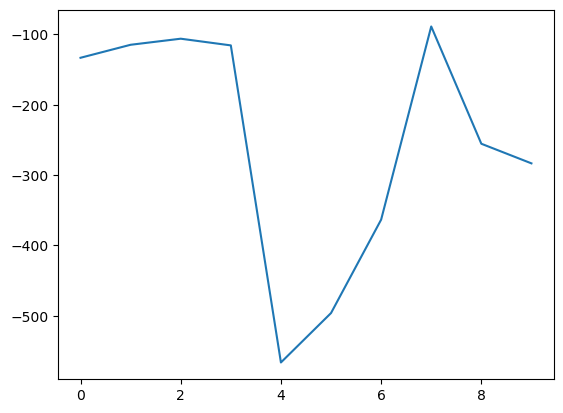

In [21]:
env = gym.make('LunarLander-v2')
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# DQN configuration

In [180]:
class DQN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size = 64) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

        # init weights
        self.apply(self._init_weights)

    def _init_weights(self,m):
        if isinstance(m,nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)  # Example: Xavier initialization
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
            
    def forward(self, X):
        return self.model(X)

# Replay Memory

In [23]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory():
    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        if batch_size > len(self.memory): return None
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

In [196]:
#Test memory
memory = ReplayMemory(capacity=10)
env = gym.make('LunarLander-v2')
obs, info = env.reset()
observation_n = len(obs)
action_n = env.action_space.n

for _ in range(10):
    state = torch.rand((1,observation_n))
    next_state = torch.rand((1,observation_n))
    action = torch.randint(0,action_n, (1,1))
    reward = torch.randint(-10,10,(1,1))
    done = torch.tensor(random.choice([True, False]), dtype = torch.int32).unsqueeze(0)

    memory.push(state, action, reward, next_state, done)

batch = memory.sample(5)
print(batch)
env.close()

[Transition(state=tensor([[0.9164, 0.3054, 0.7978, 0.6048, 0.0446, 0.2387, 0.3132, 0.4111]]), action=tensor([[1]]), reward=tensor([[-9]]), next_state=tensor([[7.0411e-01, 1.8653e-01, 3.2574e-04, 5.4540e-01, 3.0495e-01, 7.4263e-01,
         5.4667e-01, 6.1415e-01]]), done=tensor([1])), Transition(state=tensor([[0.7736, 0.9938, 0.5899, 0.0455, 0.3390, 0.5849, 0.5284, 0.9459]]), action=tensor([[0]]), reward=tensor([[-5]]), next_state=tensor([[0.3907, 0.3753, 0.2274, 0.3865, 0.1948, 0.3727, 0.7647, 0.1085]]), done=tensor([0])), Transition(state=tensor([[0.0311, 0.7260, 0.3011, 0.5568, 0.4371, 0.0079, 0.4011, 0.8247]]), action=tensor([[2]]), reward=tensor([[2]]), next_state=tensor([[0.9484, 0.0928, 0.8801, 0.9428, 0.3038, 0.2742, 0.0090, 0.3787]]), done=tensor([1])), Transition(state=tensor([[0.9312, 0.2400, 0.2866, 0.7860, 0.7020, 0.4632, 0.6382, 0.2415]]), action=tensor([[0]]), reward=tensor([[-7]]), next_state=tensor([[0.8519, 0.0792, 0.0209, 0.8586, 0.4587, 0.6269, 0.8862, 0.5668]]), do

# Epsilon Greedy

In [197]:
def select_action(state, epsilon, policy_net, env):
    p = random.random()
    #exploit
    assert torch.is_tensor(state), 'state in select action must be a tensor'
    if p > epsilon: 
        #NOTE: using eval will disable Dropout effects
        policy_net.eval()
        with torch.no_grad():
            output =  policy_net(state).max(1).indices.view(1)
        policy_net.train()

        return output
    else:
        return torch.tensor([env.action_space.sample()], dtype = torch.int64)

def epsilon_function(min_ep, max_ep, decay_ep, current_ep, total_eps, mode = 'linear'):
    return  max(min_ep, max_ep * decay_ep ** current_ep)

def epsilon_function(min_ep, max_ep, decay_ep, current_ep, total_eps, mode = 'linear'):
    return  max(min_ep, max_ep * decay_ep ** current_ep)

def linear_epsilon(min_ep, decay_ep, current_ep):
    return max(min_ep, current_ep * decay_ep)

def plot_linear_epsilon_decay(min_ep, max_ep, decay_ep, training_ep = 1000):
    eps = []
    ep = max_ep
    for t in range(training_ep):
        ep = linear_epsilon(min_ep, decay_ep, ep)
        eps.append(ep)
    sns.lineplot(y = eps, x = list(range(len(eps))))
    plt.show()

def plot_epsilon_decay(min_ep, max_ep, decay_ep, training_eps):
    eps = []
    for t in range(training_eps):
        eps.append(epsilon_function(min_ep, max_ep, decay_ep, t, training_eps))
    sns.lineplot(y = eps, x = list(range(len(eps))))
    plt.show()


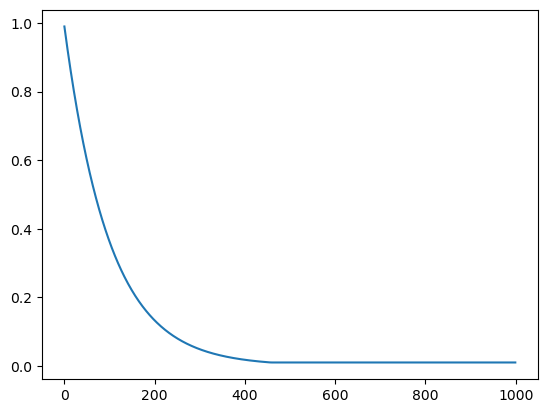

In [193]:
plot_linear_epsilon_decay(0.01, 1.0, 0.99)

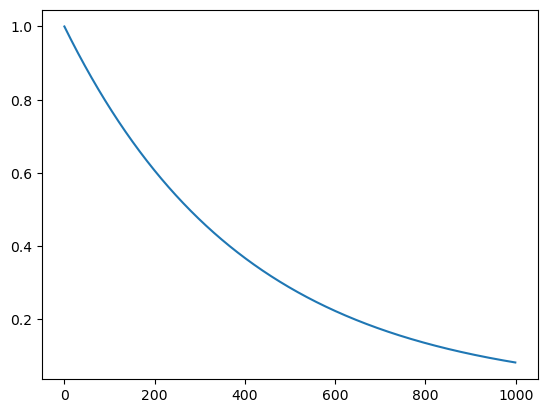

In [108]:
plot_epsilon_decay(0.01,1.0,0.9975, 1000)

# Optimize

In [94]:
# def optimize(policy_net, target_net, memory, batch_size, gamma, criterion, optimizer, debug = False, is_sync = False, tau = 1e-3):
#     transitions = memory.sample(batch_size)
#     if transitions != None:
#         batch = Transition(*zip(*transitions)) 

#         state_batch = torch.cat(batch.state) 
#         next_state_batch = torch.cat(batch.next_state) 
#         reward_batch = torch.cat(batch.reward) 
#         action_batch = torch.cat(batch.action) 
#         done_batch = torch.cat(batch.done)

#         #TD = Q(s,a) - (reward + gamma * Q(s',a'))
#         state_values = policy_net(state_batch).gather(1, action_batch)
#         next_state_values = target_net(next_state_batch).max(1).values.unsqueeze(1)
#         # print('next_state_values = ', next_state_values.shape)
#         next_state_values = reward + gamma * next_state_values * (1 - done_batch)

#         #calculate loss
#         loss = F.mse_loss(state_values, next_state_values)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if debug:
#             print('state value shape = ', state_values.shape)
#             print('next_state_values = ', next_state_values.shape)
#             print('loss = ', loss.item())
        
#         #sync target net with policy net when it's time
#         if is_sync:
#             for target_param, local_param in zip(target_net.parameters(), policy_net.parameters()):
#                 target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
                
#         return loss.item()
#     return 0.0
        


In [90]:
policy_net_test = DQN(8,4)
target_net_test = DQN(8,4)
optimizer_test = torch.optim.Adam(policy_net_test.parameters())
criterion_test = nn.MSELoss()
optimize(policy_net_test, target_net_test, memory, 5, 0.999, criterion_test, optimizer_test, debug = True, is_sync=True)

state value shape =  torch.Size([5, 1])
next_state_values =  torch.Size([5, 5])
loss =  5.1086506843566895


# Training looop

In [93]:
epsilon = epsilon_function(0.01, 1.0, 0.9975, 500, 1000)
print(epsilon)

0.28605673633036893


In [203]:
def tune(policy_net, target_net, optimizer, criterion, memory: ReplayMemory, batch_size, gamma, env,
    training_epochs = 1000, min_ep = 0.01, max_ep = 1.0, decay_ep = 0.9975, c = 4, tau = 1e-3, debug = False):
    # C is target net update frequency

    reward_window = deque(maxlen=100)

    loop = tqdm(range(training_epochs))
    history = defaultdict(list)
    # print('tune')
    sync_count = 0
    epsilon = max_ep

    for epoch in loop:
        state, info = env.reset(seed = 0)
        state = torch.tensor([state], dtype = torch.float32)
        epsilon = linear_epsilon(min_ep, decay_ep, epsilon)

        total_reward = 0

        for t in count():
            #get action
            action = select_action(state, epsilon, policy_net, env)
            next_state, reward, terminated, truncated, info = env.step(action.item())

            total_reward += reward

            next_state = torch.tensor([next_state], dtype = torch.float32)
            reward = torch.tensor([reward])
            action = action.unsqueeze(1)

            if terminated or truncated:
                done = True
            else:
                done = False
            
            done_tensor = torch.tensor([done], dtype= torch.int32)
            memory.push(state, action, reward, next_state, done_tensor)

            is_sync = (epoch % c == 0)

            #optimize

            transitions = memory.sample(batch_size)

            if transitions != None:
                batch = Transition(*zip(*transitions)) 

                state_batch = torch.cat(batch.state) 
                next_state_batch = torch.cat(batch.next_state) 
                reward_batch = torch.cat(batch.reward) 
                action_batch = torch.cat(batch.action) 
                done_batch = torch.cat(batch.done)

                if debug:
                    print('action batch shape = ', action_batch.shape)
                    print('state batch shape = ', state_batch.shape)

                #TD = Q(s,a) - (reward + gamma * Q(s',a'))
                state_values = policy_net(state_batch).gather(1, action_batch)

                next_state_values = target_net(next_state_batch).max(1)[0].unsqueeze(1)

                # print('next_state_values = ', next_state_values.shape)
                next_state_values = reward_batch + gamma * next_state_values * (1 - done_batch)
                next_state_values = next_state_values.to(torch.float32)

                #calculate loss
                loss = criterion(state_values, next_state_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if debug:
                    print('state value shape = ', state_values.shape)
                    print('next_state_values = ', next_state_values.shape)
                    print('loss = ', loss.item())
                
                #sync target net with policy net when it's time
                if is_sync:
                    sync_count += 1
                    for target_param, local_param in zip(target_net.parameters(), policy_net.parameters()):
                        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
                        

            if done:
                break
        
        reward_window.append(total_reward)
        loop.set_description(f'epsilon = {epsilon:.2f}, average reward = {np.mean(reward_window):.2f}, sync_count = {sync_count}')
        history['rewards'].append(np.mean(reward_window))
    
    return history

def plot(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    sns.lineplot(y = history['rewards'], x = list(range(len(history['rewards']))), ax = ax1, color = 'green')
    # ax1.set_title('rewards')
    # sns.lineplot(y = history['loss'], x = list(range(len(history['loss']))), ax = ax2)
    # ax2.set_title('loss')
    # plt.show()
    # sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))))
    # plt.title('epsilon')
    plt.show()


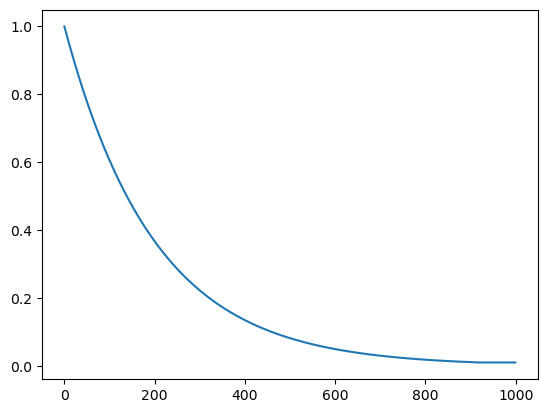

In [184]:
plot_epsilon_decay(0.01, 1.0, 0.995, 1000)

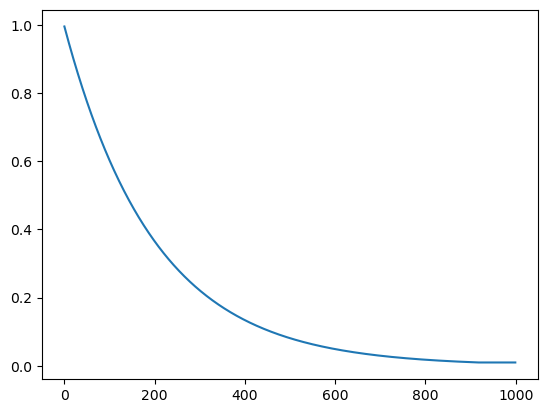

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
epsilon = 0.08, average reward = -298.22, sync_count = 14477: 100%|██████████| 1000/1000 [01:02<00:00, 15.88it/s]


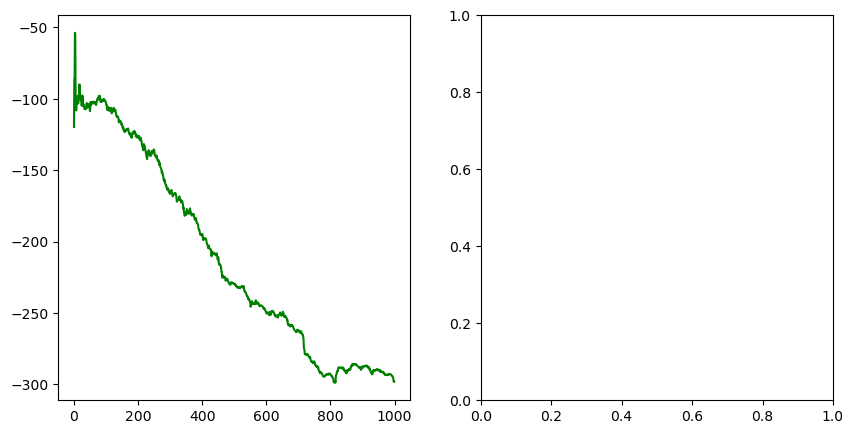

In [204]:
def exp1():
    env = gym.make("LunarLander-v2")
    obs, info = env.reset(seed = 0)

    observation_n = len(obs)
    action_n = env.action_space.n

    policy_net = DQN(observation_n, action_n)
    target_net = DQN(observation_n, action_n)
    optimizer = torch.optim.Adam(policy_net.parameters(), lr = 5e-4)
    criterion = nn.MSELoss()
    memory = ReplayMemory(capacity=10000)

    min_ep = 0.01
    max_ep = 1.0
    decay_ep = 0.995
    training_epochs = 1000


    plot_linear_epsilon_decay(min_ep, max_ep, decay_ep, training_epochs)

    history = tune(policy_net, target_net, optimizer, criterion, 
        memory, batch_size = 64, gamma = 0.99, env = env, training_epochs=1000)
    
    plot(history)

exp1()
